In [18]:
import pandas as pd
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# directory - only train for now
train_dir = Path('train')

# Iinitliase list to store values
processed_data = []

# consider each file in train folder
for folder in train_dir.iterdir():
    if folder.is_dir():
        # paths containing data 
        target_path = folder / 'targets.csv'
        acc_path = folder / 'acceleration.csv'
        acclean_path = folder / 'acceleration_clean.csv' # used clean to compare NaN from acc but should revert back to only acc
        pir_path = folder / 'pir.csv'

        video_hallway_path = folder / 'video_hallway.csv'
        video_kitchen_path = folder / 'video_kitchen.csv'
        video_living_room_path = folder / 'video_living_room.csv'
        
        # check for sanity - should always be ok
        if target_path.exists() and acc_path.exists() and pir_path.exists():
            target_data = pd.read_csv(target_path)
            acc_data = pd.read_csv(acc_path)
            acclean_data = pd.read_csv(acclean_path)
            pir_data = pd.read_csv(pir_path)

            video_hallway_data = pd.read_csv(video_hallway_path) if video_hallway_path.exists() else pd.DataFrame()
            video_kitchen_data = pd.read_csv(video_kitchen_path) if video_kitchen_path.exists() else pd.DataFrame()
            video_living_room_data = pd.read_csv(video_living_room_path) if video_living_room_path.exists() else pd.DataFrame()
            
            # consider each sequence separately
            for _, target_row in target_data.iterrows():
                start_time = target_row['start']
                end_time = target_row['end']
                
                # Acceleration data analysis
                
                # clean dataset for x y and z mean 
                acc_interval_clean_data = acclean_data[(acclean_data['start'] >= start_time) & (acclean_data['end'] <= end_time)]
        
                x_mean = acc_interval_clean_data['x_mean'].mean()
                y_mean = acc_interval_clean_data['y_mean'].mean()
                z_mean = acc_interval_clean_data['z_mean'].mean()

                # calculate the mean and standard deviation for Kitchen_AP, Lounge_AP, Upstairs_AP, Study_AP
                acc_interval_data = acc_data[(acc_data['t'] >= start_time) & (acc_data['t'] <= end_time)]
                
                kitchen_ap_mean = acc_interval_data['Kitchen_AP'].mean()
                lounge_ap_mean = acc_interval_data['Lounge_AP'].mean()
                upstairs_ap_mean = acc_interval_data['Upstairs_AP'].mean()
                study_ap_mean = acc_interval_data['Study_AP'].mean()
                
                # PIR data analysis

                # filter pir as before
                active_pirs = pir_data[(pir_data['start'] <= end_time) & (pir_data['end'] >= start_time)]
                
                #  just count the number of different PIR activations  (for smplicity THIS CAN BE EXPANDED UPON)
                pir_counts = len(active_pirs)

                # Video data analysis
                # for simplicity, just activate if video record movement in sequence

                hallway_activation = 1 if not video_hallway_data[(video_hallway_data['t'] >= start_time) & (video_hallway_data['t'] <= end_time)].empty else 0
                kitchen_activation = 1 if not video_kitchen_data[(video_kitchen_data['t'] >= start_time) & (video_kitchen_data['t'] <= end_time)].empty else 0
                living_room_activation = 1 if not video_living_room_data[(video_living_room_data['t'] >= start_time) & (video_living_room_data['t'] <= end_time)].empty else 0

                
                # determine the highest likelihood activity
                activity_labels = target_row.iloc[2:]
                if activity_labels.isna().all():
                    highest_likelihood_activity = 'No activity detected'
                else:
                    highest_likelihood_activity = activity_labels.idxmax()
                
                # append the results
                processed_data.append([
                    x_mean, y_mean,  z_mean,
                    kitchen_ap_mean, lounge_ap_mean, upstairs_ap_mean, study_ap_mean,
                    pir_counts,
                    hallway_activation, kitchen_activation, living_room_activation,
                    highest_likelihood_activity
                ])

# store in datafrme
columns = [
    'X Mean',  'Y Mean',  'Z Mean', 
    'Kitchen_AP Mean', 'Lounge_AP Mean','Upstairs_AP Mean', 'Study_AP Mean', 
    'PIR Activations',
    'H activation', 'K activation', 'LR activation',
    'Highest Likelihood Activity'
]
processed_df = pd.DataFrame(processed_data, columns=columns)

processed_df

,X Mean,Y Mean,Z Mean,Kitchen_AP Mean,Lounge_AP Mean,Upstairs_AP Mean,Study_AP Mean,PIR Activations,H activation,K activation,LR activation,Highest Likelihood Activity
0,0.967,-0.451,0.026,-73.400000,-85.2000,-76.750000,NaN,2,0,0,0,a_walk
1,0.377,-0.409,0.759,-90.384615,-75.4500,-90.800000,NaN,2,0,0,0,a_walk
2,0.681,-0.360,0.567,NaN,-68.9000,-93.000000,NaN,2,0,0,0,a_walk
3,0.857,-0.446,0.259,-102.000000,-79.1500,-97.909091,NaN,1,0,0,0,p_stand
4,0.678,-0.625,0.254,-96.666667,-81.3125,-91.000000,NaN,1,0,0,0,p_stand
...,...,...,...,...,...,...,...,...,...,...,...,...
16118,-0.869,0.364,0.114,-81.400000,NaN,-88.600000,-79.2,0,0,0,0,p_stand
16119,-0.871,0.362,0.111,-81.400000,NaN,-88.400000,-80.2,0,0,0,0,p_stand
16120,-0.867,0.359,0.113,-81.600000,NaN,-88.200000,-78.0,0,0,0,0,p_stand
16121,-0.871,0.358,0.104,-81.600000,NaN,-86.200000,-80.8,0,0,0,0,p_stand


In [3]:
# Deal with NaN (not acceptable in RT)

# for data from acc impute the mean (as over 2000 entires have NaN not considering them would significantly lower the datset)
imputer_mean = SimpleImputer(strategy='mean')
columns_to_impute = ['X Mean', 'Y Mean', 'Z Mean']
processed_df[columns_to_impute] = imputer_mean.fit_transform(processed_df[columns_to_impute])

# for AP place -100 as the distance is far away
for column in ['Kitchen_AP Mean', 'Lounge_AP Mean','Upstairs_AP Mean', 'Study_AP Mean',]:
    processed_df[column].fillna(-100, inplace=True)


In [22]:
# prep X and Y from datset
X = processed_df.drop('Highest Likelihood Activity', axis=1)
y = processed_df['Highest Likelihood Activity']

# split it as you wish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train # choose model
#clf = RandomForestClassifier(random_state=42)
#clf = SVC(kernel='linear', random_state=42)
#clf = KNeighborsClassifier(n_neighbors=3)
# clf = GradientBoostingClassifier(random_state=42)
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

# print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5259


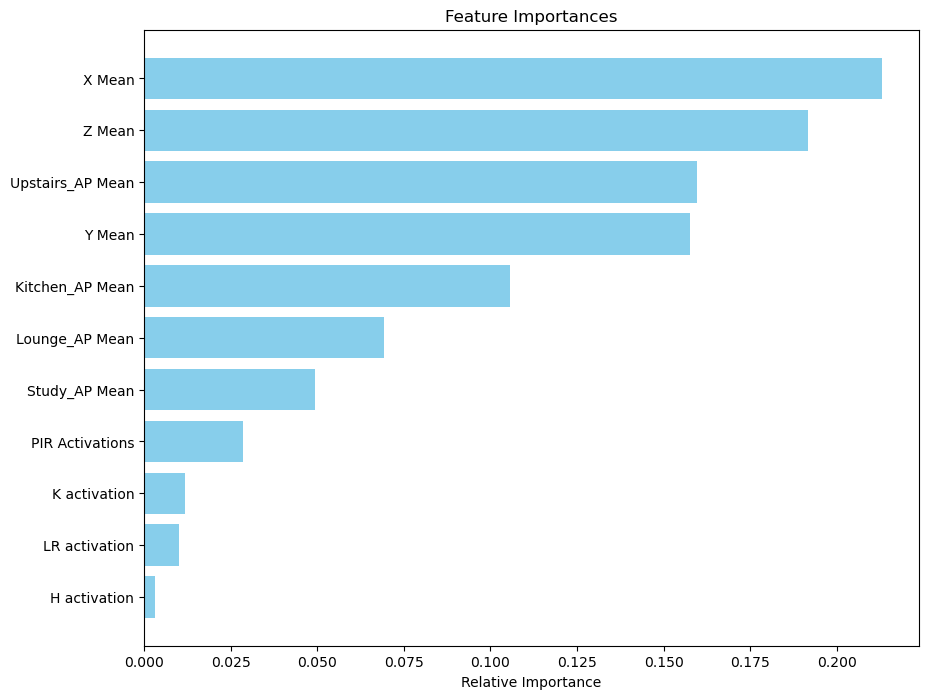

In [23]:
# Feature Engineering - method 1 - does not work with SVM

# get feature importances - from built in command
importances = clf.feature_importances_

# convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# sort the DataFrame to find out the most important features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Relative Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis() 
plt.show()


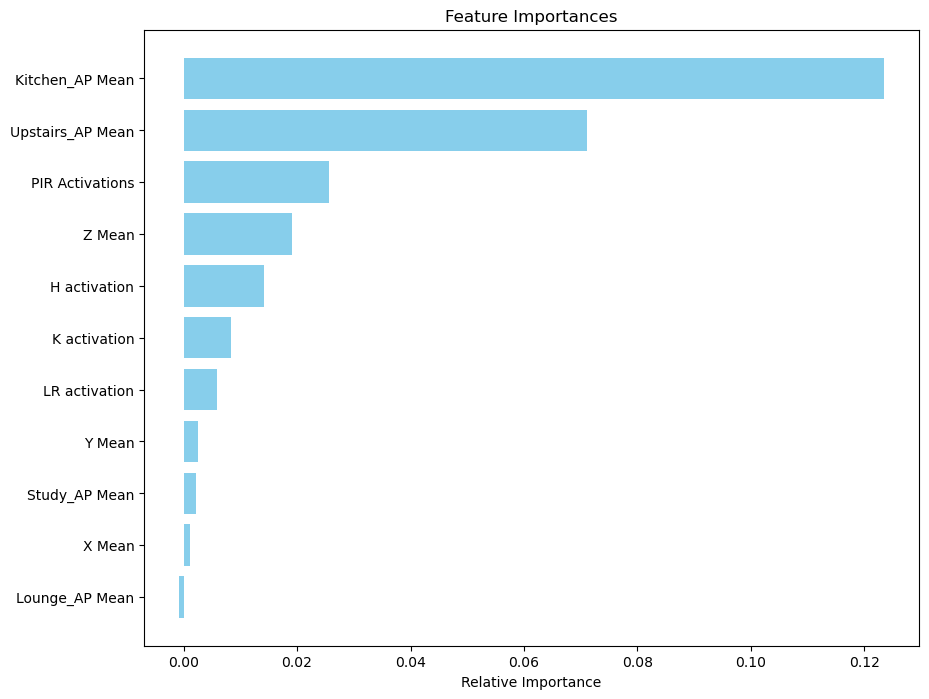

In [14]:
# Feature Engineering - method 2


# perform permutation importance
results = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': results.importances_mean
})

# sort the DataFrame to find out the most important features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Relative Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis() 
plt.show()



In [15]:
feature_importance_df

,Feature,Importance
3,Kitchen_AP Mean,0.123465
5,Upstairs_AP Mean,0.071180
7,PIR Activations,0.025553
2,Z Mean,0.019041
8,H activation,0.014100
9,K activation,0.008290
10,LR activation,0.005933
1,Y Mean,0.002502
6,Study_AP Mean,0.002212
0,X Mean,0.001075


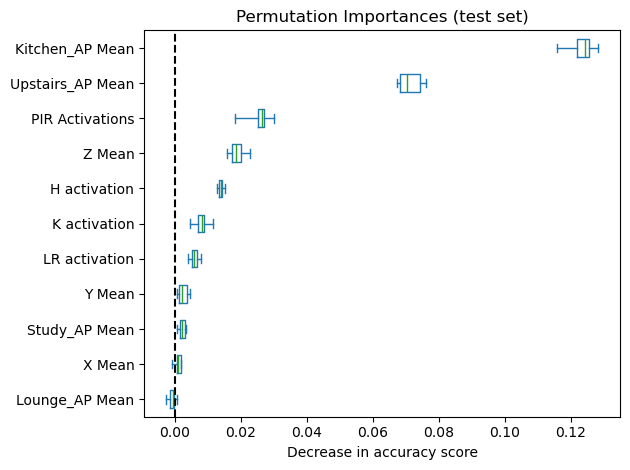

In [16]:
# consider only test (from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)
result_test = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_importances_idx = result_test.importances_mean.argsort()
importances = pd.DataFrame(
    result_test.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

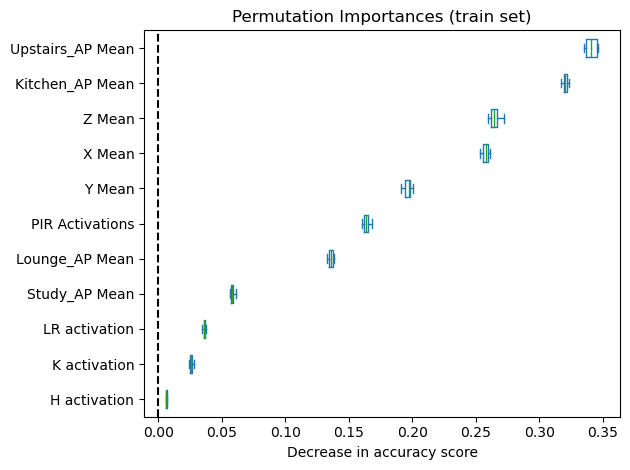

In [9]:
# consider only train dataset
result_train = permutation_importance(
    clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

# same as above ( from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)
sorted_importances_idx = result_train.importances_mean.argsort()
importances = pd.DataFrame(
    result_train.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# plot
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()